# XGBoost Forecasting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('ggplot')

In [3]:
# Import Dataset
df_boost = pd.read_csv('C:/Users/johnk/Desktop/TSF/Task 7/PSEI(2014-2024).csv')
df_boost['Date'] = pd.to_datetime(df_boost['Date'])
df_boost.dropna(inplace = True)
df_boost.drop(axis = 1, columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True)
df_boost.set_index('Date', inplace=True)
df_boost.sort_index(inplace=True)
df_boost

,Close
Date,
2014-04-01,6514.720215
2014-04-02,6587.720215
2014-04-03,6587.080078
2014-04-04,6561.200195
2014-04-07,6614.399902
...,...
2024-03-21,6963.220215
2024-03-22,6881.970215
2024-03-25,6853.100098


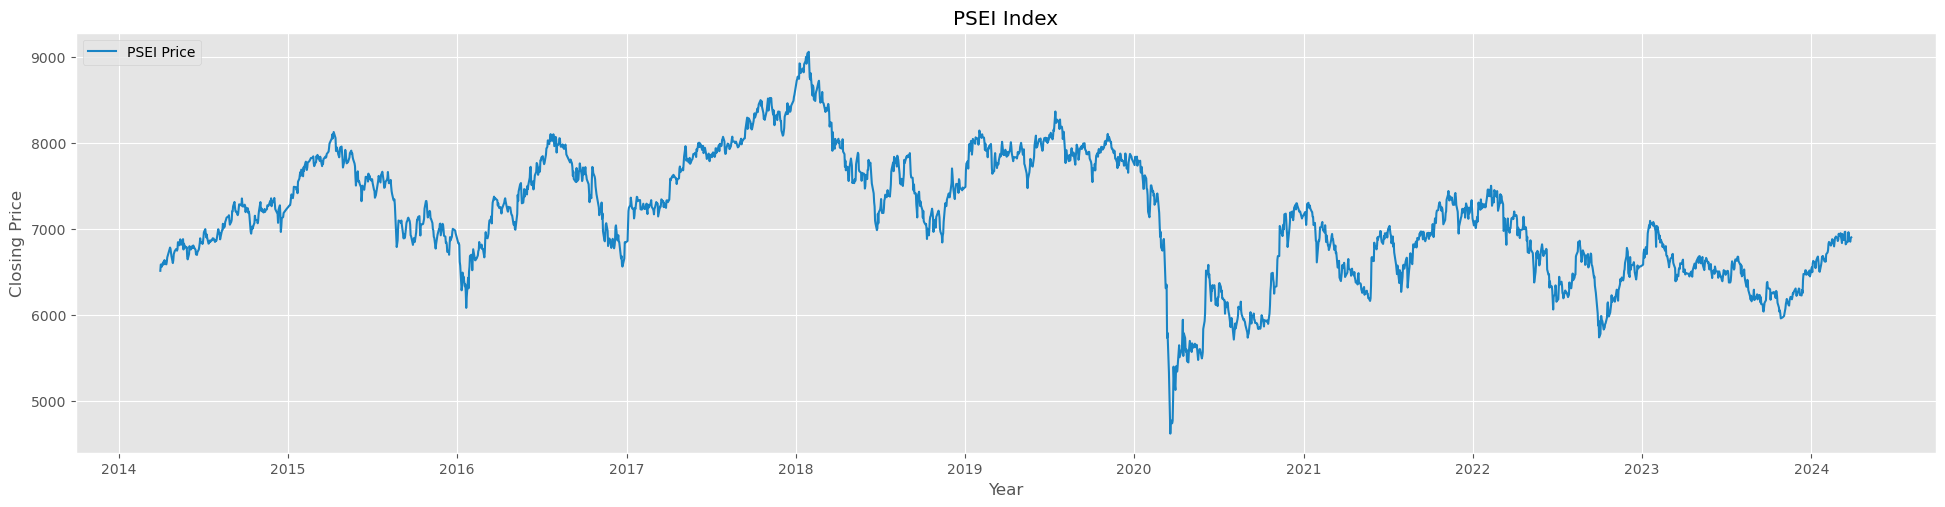

In [4]:
plt.figure(figsize=(24, 12))

plt.subplot(2,1,2)
plt.plot(df_boost.index, df_boost['Close'], color='#1984c5', label='PSEI Price')
plt.ylabel('Closing Price')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.title('PSEI Index')
plt.show()

## Time Series Cross Validation

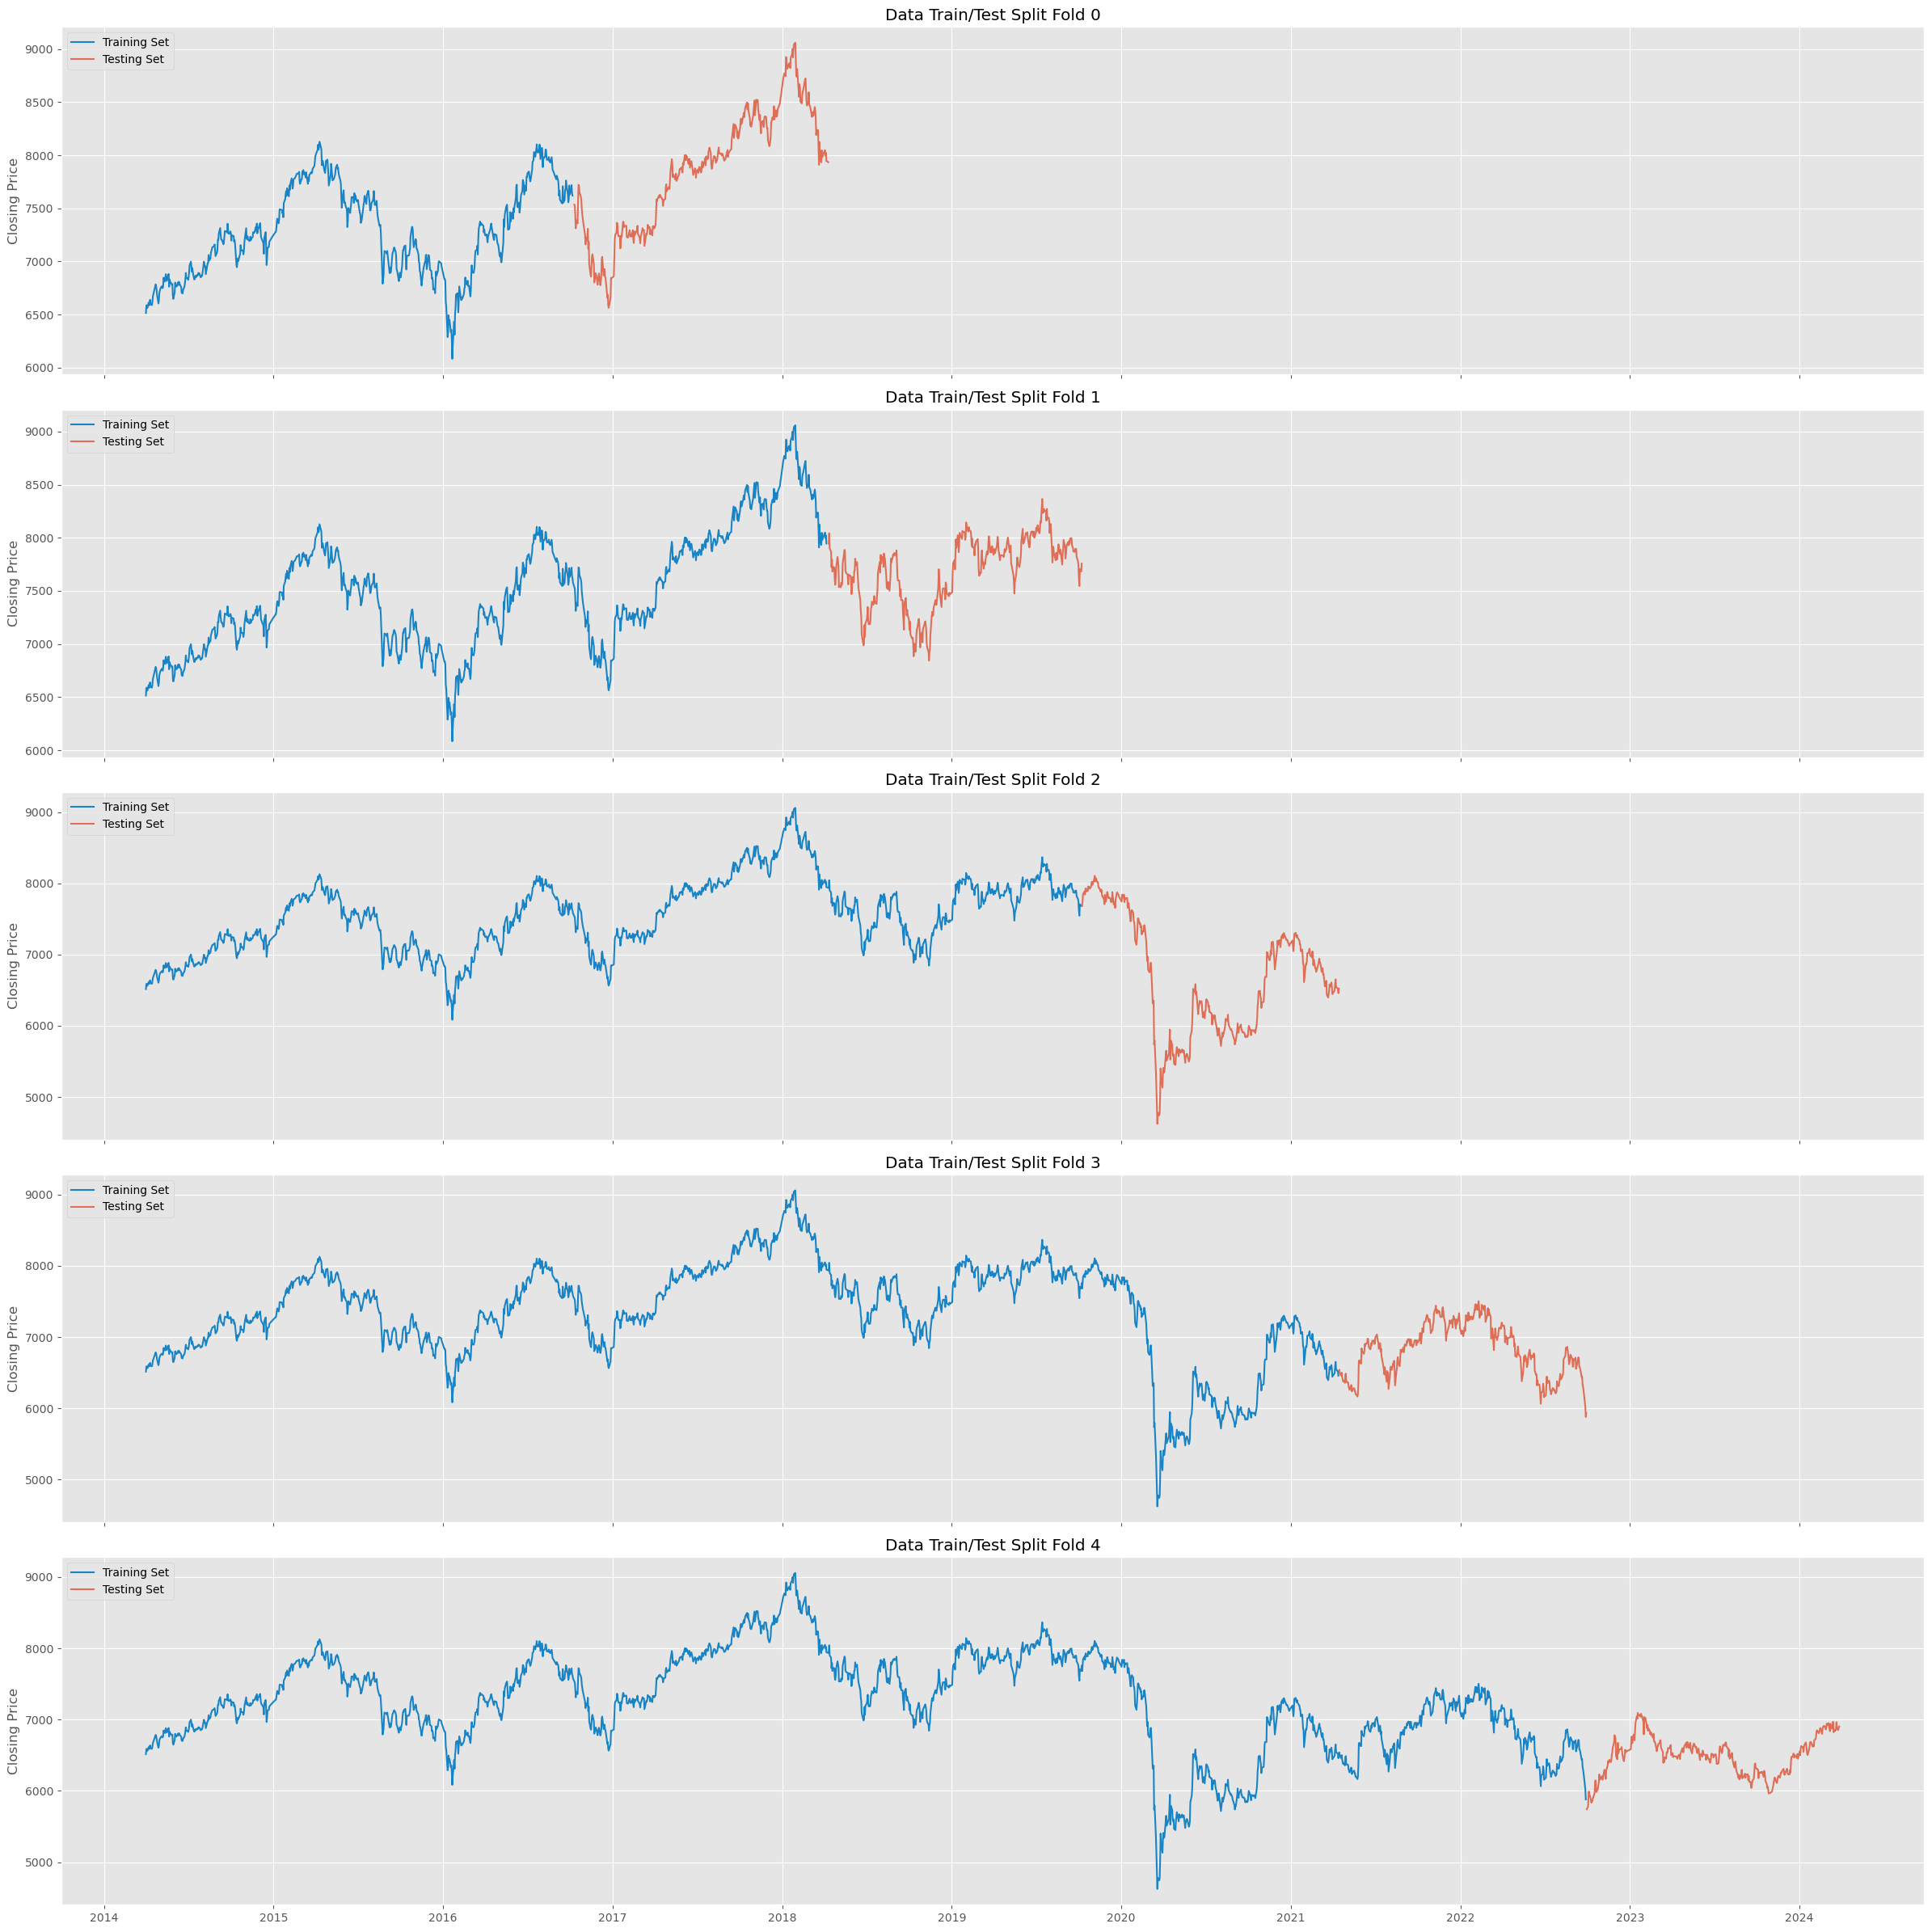

In [5]:
xgb_tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)

fig, axs = plt.subplots(5, 1, figsize=(24,24), sharex=True)

fold = 0
for xgb_train_idx, xgb_val_idx in xgb_tss.split(df_boost):
    xgb_train = df_boost.iloc[xgb_train_idx]
    xgb_test = df_boost.iloc[xgb_val_idx]
    ax = axs[fold]
    axs[fold].plot(xgb_train.index, xgb_train['Close'], color='#1984c5', label='Training Set')
    axs[fold].plot(xgb_test.index, xgb_test['Close'], color='#de6e56', label='Testing Set')
    axs[fold].set_title(f'Data Train/Test Split Fold {fold}')
    axs[fold].legend(loc = 'upper left')
    axs[fold].set_ylabel('Closing Price')

    fold += 1

plt.tight_layout()
plt.show()

## Feature Creation

In [6]:
# Create Time Series Features based on time series index
def create_features(df):
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

# Create Lagged Features
def create_lag(df):
    xgb_target_map = df['Close'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(xgb_target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(xgb_target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(xgb_target_map)
    return df

df_boost = create_features(df_boost)
df_boost = create_lag(df_boost)
df_boost

,Close,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Date,,,,,,,,,,,
2014-04-01,6514.720215,1,2,4,2014,91,1,14,NaN,NaN,NaN
2014-04-02,6587.720215,2,2,4,2014,92,2,14,NaN,NaN,NaN
2014-04-03,6587.080078,3,2,4,2014,93,3,14,NaN,NaN,NaN
2014-04-04,6561.200195,4,2,4,2014,94,4,14,NaN,NaN,NaN
2014-04-07,6614.399902,0,2,4,2014,97,7,15,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,6963.220215,3,1,3,2024,81,21,12,6536.359863,7082.609863,6581.000000
2024-03-22,6881.970215,4,1,3,2024,82,22,12,6602.169922,7124.839844,6544.629883
2024-03-25,6853.100098,0,1,3,2024,85,25,13,6595.029785,7134.359863,6607.779785


## Building & Training the Model

In [76]:
# Create Model
xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=50, objective='reg:squarederror', max_depth=3, learning_rate=0.03)

# Loop for the cross validation
fold = 1
preds = []
scores = []

for xgb_train_idx, xgb_val_idx in xgb_tss.split(df_boost):
    print(f'Cross Validation Fold {fold}')

    xgb_train = df_boost.iloc[xgb_train_idx].copy()
    xgb_test = df_boost.iloc[xgb_val_idx].copy()

    xgb_train = create_features(xgb_train)
    xgb_test = create_features(xgb_test)

    xgb_features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
    xgb_target = 'Close'

    xgb_X_train = xgb_train[xgb_features]
    xgb_y_train = xgb_train[xgb_target]

    xgb_X_test = xgb_test[xgb_features]
    xgb_y_test = xgb_test[xgb_target]

    xgb_reg.fit(xgb_X_train, xgb_y_train, eval_set=[(xgb_X_train, xgb_y_train), (xgb_X_test, xgb_y_test)], verbose=100)

    xgb_y_pred = xgb_reg.predict(xgb_X_test)
    preds.append(xgb_y_pred)
    score = np.sqrt(mean_squared_error(xgb_y_test, xgb_y_pred))
    scores.append(score)

    fold += 1

Cross Validation Fold 1
[0]	validation_0-rmse:7074.48605	validation_1-rmse:7653.03555


[100]	validation_0-rmse:396.71807	validation_1-rmse:1031.75030
[200]	validation_0-rmse:143.46797	validation_1-rmse:831.50721
[256]	validation_0-rmse:130.88095	validation_1-rmse:834.68378
Cross Validation Fold 2
[0]	validation_0-rmse:7289.25617	validation_1-rmse:7455.62200
[100]	validation_0-rmse:425.55925	validation_1-rmse:418.47147
[154]	validation_0-rmse:205.25765	validation_1-rmse:508.62592
Cross Validation Fold 3
[0]	validation_0-rmse:7338.25104	validation_1-rmse:6485.89930
[100]	validation_0-rmse:430.30768	validation_1-rmse:1147.74722
[112]	validation_0-rmse:339.35528	validation_1-rmse:1230.54865
Cross Validation Fold 4
[0]	validation_0-rmse:7171.53515	validation_1-rmse:6644.50965
[100]	validation_0-rmse:443.69097	validation_1-rmse:855.58674
[200]	validation_0-rmse:218.50408	validation_1-rmse:567.66446
[300]	validation_0-rmse:182.52463	validation_1-rmse:521.57821
[400]	validation_0-rmse:168.43295	validation_1-rmse:485.56126
[500]	validation_0-rmse:156.36073	validation_1-rmse:472.9

In [81]:
preds

[array([7635.203 , 7635.951 , 7668.923 , 7635.951 , 7635.951 , 7635.951 ,
        7635.951 , 7635.951 , 7635.203 , 7635.203 , 7645.3164, 7641.202 ,
        7641.202 , 7625.502 , 7647.0864, 7613.977 , 7647.0864, 7647.0864,
        7647.8345, 7647.8345, 7647.8345, 7680.806 , 7680.806 , 7683.0815,
        7680.806 , 7723.6143, 7723.6143, 7680.806 , 7647.8345, 7647.8345,
        7647.8345, 7647.8345, 7680.806 , 7723.6143, 7647.8345, 7647.8345,
        7680.806 , 7467.2383, 7680.806 , 7687.779 , 7687.779 , 7635.0024,
        7421.3887, 7421.3887, 7474.165 , 7474.165 , 7474.165 , 7474.165 ,
        7448.653 , 7096.7095, 7241.2017, 7241.2017, 7221.552 , 7241.2017,
        7241.2017, 7255.673 , 7255.673 , 7415.93  , 7415.93  , 7378.858 ,
        7378.858 , 7292.166 , 7556.668 , 7556.668 , 7292.166 , 7292.166 ,
        7292.166 , 7269.3857, 7269.3857, 7333.211 , 7333.211 , 7295.923 ,
        7295.923 , 7243.8413, 7390.7085, 7490.0635, 7544.6562, 7453.3057,
        7415.2866, 7262.9766, 7545.341

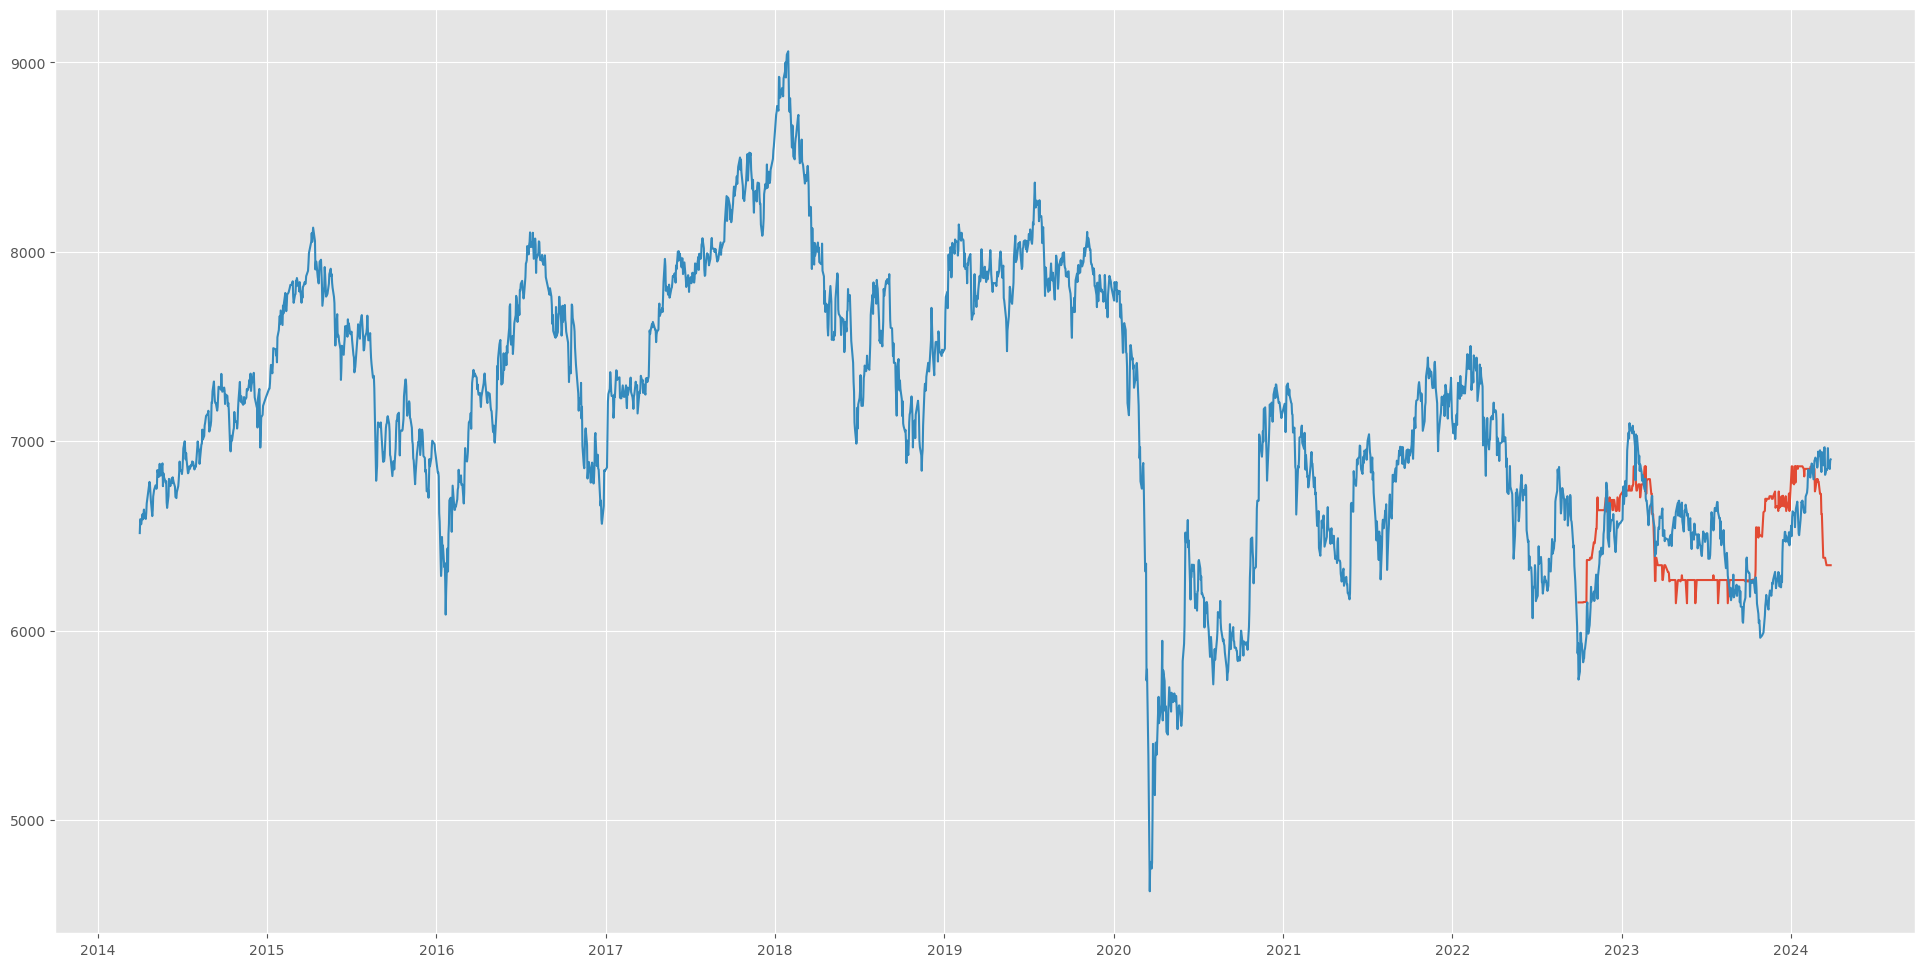

In [86]:
plt.figure(figsize=(24,12))
plt.plot(xgb_X_test.index, preds[4])
plt.plot(df_boost.index, df_boost['Close'])
# plt.plot(preds)

ValueError: x and y must have same first dimension, but have shapes (365,) and (5, 365)

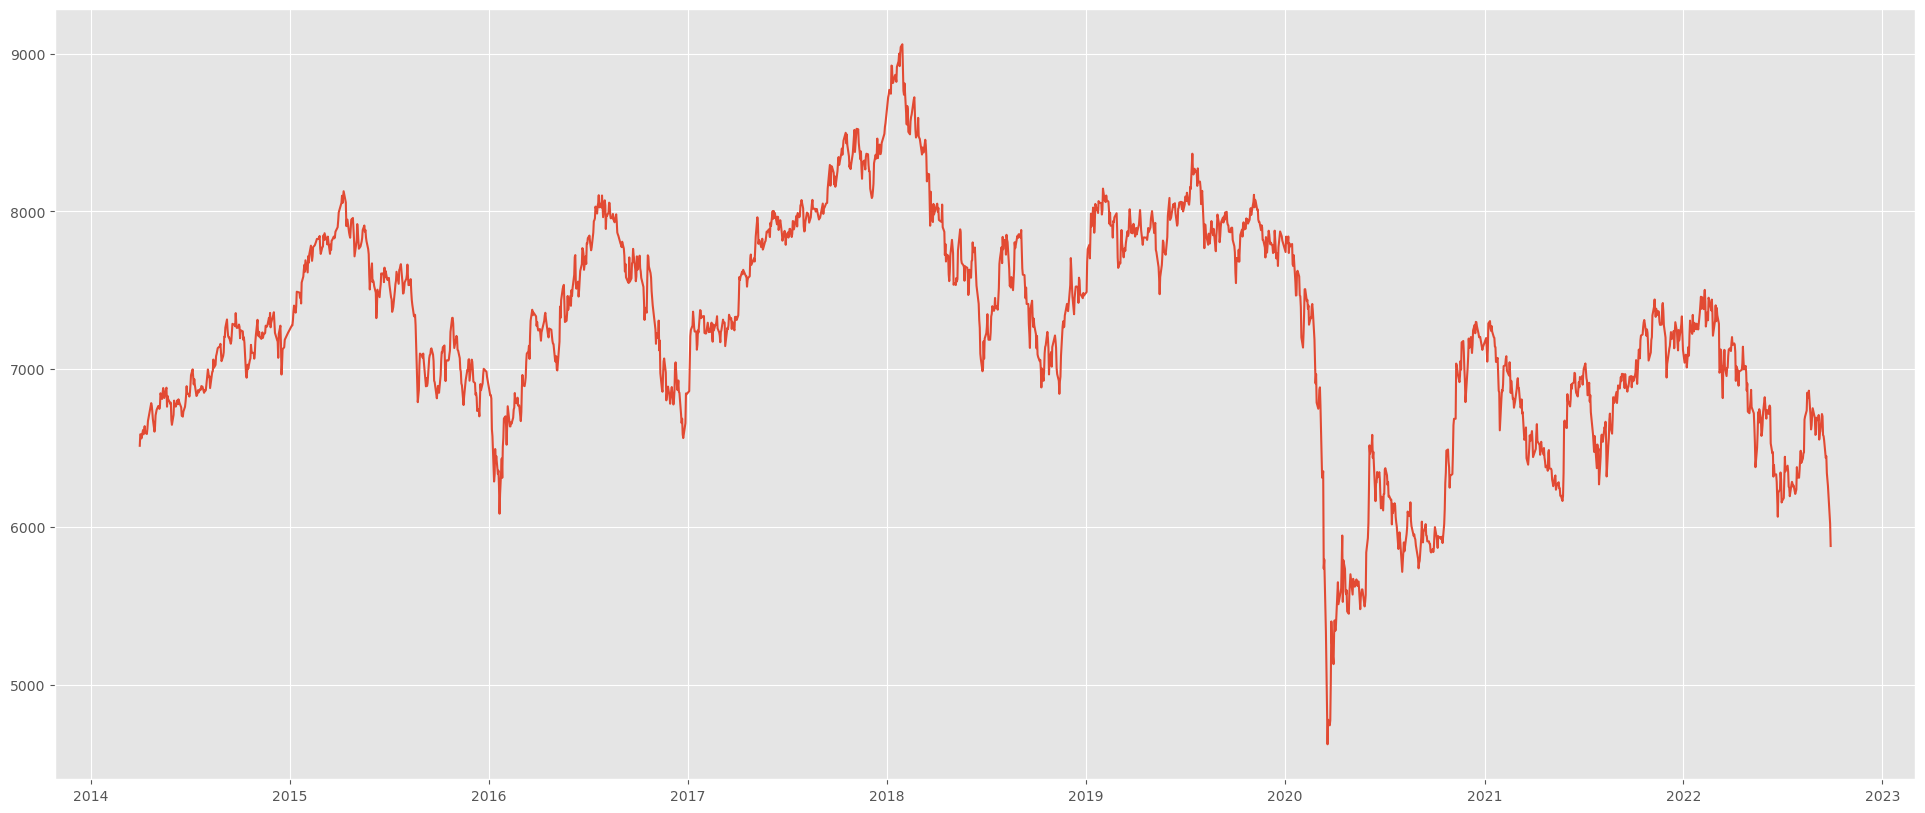

In [52]:
# Plot actual vs predicted unseen data
plt.figure(figsize=(24, 10))
plt.plot(xgb_train.index, xgb_train['Close'], label = 'Close Price')
plt.plot(xgb_X_test.index, preds, label = 'Predictions' )
plt.legend()
plt.show()